[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/matteo-bertini/Facial-Expression-Recognition)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matteo-bertini/Facial-Expression-Recognition/blob/main/Five_Layers_CNN.ipynb)

# Importing the libraries
The libraries to implement Five-Layers-CNN and related utilities are imported here.

In [1]:
import random
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import tensorflow as tf
from tensorflow import keras
from keras.applications import ResNet152V2 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D,ReLU
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# GPU Check
This section checks whether the GPU is in use or not.

In [2]:
num_gpu_available = len(tf.config.list_physical_devices('GPU'))
if num_gpu_available == 0 :
  print("You are not using GPU.\n")
else:
  print("You are using GPU.\n")

You are using GPU.



In [3]:
# Command to run to see the specs of the assigned GPU. (only valid if GPU is in use)
!nvidia-smi

Tue Jan 10 13:18:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    29W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mounting Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Dataset
The dataset provided by the .csv file is uploaded and processed here.


## Loading the dataset from the csv file
In this section the file "icml_face_data.csv" is loaded inside a dataframe, which is processed and then divided into three other dataframes (one for train, one for validation and one for test) according to the value of the "usage" column.

In [5]:
# Loading icml_face_data.csv into dataframe df_icml
df_icml = pd.read_csv("/content/drive/MyDrive/Facial-Expression-Recognition/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv",sep=",")

# Columns renamed for easier access.
df_icml.rename(columns = {' Usage':'usage'}, inplace = True)
df_icml.rename(columns = {' pixels':'pixels'}, inplace = True)

# Transforming pixel strings into 48x48x1 numpy arrays of float32
df_icml["pixels"] = df_icml['pixels'].apply(lambda x: np.array(x.split()).reshape(48, 48,1).astype('float32'))
# Transforming 48x48x1 numpy arrays into 48x48x3 by coping the first channel
df_icml["pixels"] = df_icml["pixels"].apply(lambda x : np.repeat(a=x,repeats=3,axis = 2))

# Creating the df_train,df_val_df_test dataframes
df_train = df_icml.loc[df_icml['usage'].isin(["Training"])]
df_val = df_icml.loc[df_icml['usage'].isin(["PrivateTest"])]
df_test = df_icml.loc[df_icml['usage'].isin(["PublicTest"])]


## Creating the Train-Val-Test split
Here the dataframes for training, validation and testing are processed to be in a format acceptable to the neural network.

In [6]:



# Creating the train,val,test split accordingly to the specifics of the poject.

le = LabelEncoder()                                                               # declaration of the label encoder to later transform the labels

# Train 
X_train = df_train['pixels']
X_train = np.stack(X_train, axis=0)
print("X_train has shape: ")
print(X_train.shape)
y_train = df_train["emotion"].to_numpy()
y_train = to_categorical(y_train)
print("y_train has shape: ")
print(y_train.shape)

# Validation
X_val = df_val['pixels']
X_val = np.stack(X_val, axis=0)
print("X_val has shape: ")
print(X_val.shape)
y_val = df_val["emotion"].to_numpy()
y_val = to_categorical(y_val)
print("y_val has shape: ")
print(y_val.shape)

# Test
X_test = df_test['pixels']
X_test = np.stack(X_test, axis=0)
print("X_test has shape: ")
print(X_test.shape)
y_test = df_test["emotion"].to_numpy()                                        
y_test = to_categorical(y_test)
print("y_test has shape: ")
print(y_test.shape)




X_train has shape: 
(28709, 48, 48, 3)
y_train has shape: 
(28709, 7)
X_val has shape: 
(3589, 48, 48, 3)
y_val has shape: 
(3589, 7)
X_test has shape: 
(3589, 48, 48, 3)
y_test has shape: 
(3589, 7)


# Loading the ResNet152V2 from saved file
In this section the ResNet152V2 model is loaded in its entirety.
Specifically, the network structure (the various layers) will be loaded together with the various weights learned during the training phase.
If you choose to upload the model there is no need to train the network and you can go directly to the testing section.

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/Facial-Expression-Recognition/ResNet152V2.h5")
model.summary()

# Downloading the ResNet152V2 


## Creating the network structure
Here the architecture of ResNet152V2 is imported from the library.


In [44]:
model = ResNet152V2(include_top = True,weights=None,input_shape=(48,48,3),pooling="max",classes=7)
model._name = "ResNet152V2"

# After creating the structure of the network, we visualize it in a compact way.
model.summary()

Model: "ResNet152V2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 26, 26, 64)   0           ['conv1_conv[0][0]']             
                                                                                        

## Compiling the model
In this section the model is compiled, in particular are defined:


*   the loss function (categorical crossentropy)
*   the optimizator (adam optimizer)
*   the evaluation metrics (accuracy)







In [16]:
# defining the loss function,the optimizer and the evaluation metrics
opt = keras.optimizers.Adam()
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = opt,
    metrics = ['accuracy']
)


In [17]:
early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=1,
    min_lr=0.0001,
    verbose=1,
    
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

# Training the ResNet152V2
in this section the net is trained on the training set.

In [43]:
print("Training:\n")
history = model.fit(X_train,y_train,batch_size=32,epochs=15,callbacks=callbacks,validation_data=(X_val, y_val))


Training:

Epoch 1/15
898/898 [==============================] - 107s 118ms/step - loss: 0.4850 - accuracy: 0.8288 - val_loss: 1.6034 - val_accuracy: 0.5595 - lr: 1.0000e-04
Epoch 2/15
109/898 [==>...........................] - ETA: 1:29 - loss: 0.4483 - accuracy: 0.8481

KeyboardInterrupt: ignored

# Learning curves visualization
Here the learning curves are displayed.
In particular, it is displayed how the loss and accuracy change for the training set and for the validation set during the various training epochs.

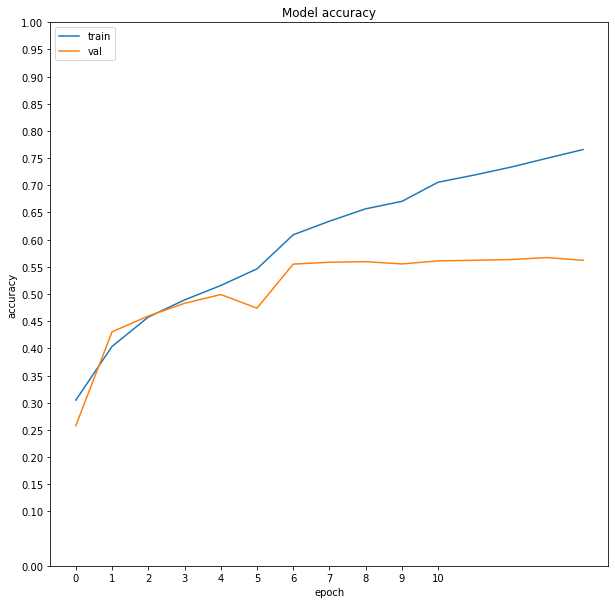

In [19]:
# visualizing the accuracy learning curves

# creating the figure
acc_lc = plt.figure(figsize = (10,10))

# plotting training and validation accuracy
plt.plot(history.history['accuracy'])                                                         
plt.plot(history.history['val_accuracy'])  

# setting plot title
plt.title('Model accuracy')

# setting x and y ticks and labels for the plot
plt.ylabel('accuracy')
plt.yticks([0.0,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.0])
plt.xlabel('epoch')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])

# setting the legend for the plot
plt.legend(['train', 'val'], loc='upper left')

# showing the figure
plt.show(acc_lc)

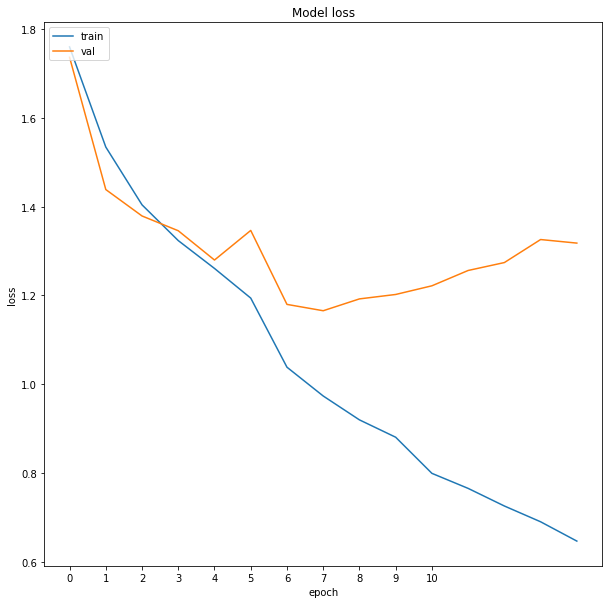

In [20]:
# visualizing the loss learning curves

# creating the figure
loss_lc = plt.figure(figsize = (10,10))

# plotting training and validation accuracy
plt.plot(history.history['loss'])                                                         
plt.plot(history.history['val_loss'])  

# setting plot title
plt.title('Model loss')

# setting x and y ticks and labels for the plot
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])

# setting the legend for the plot
plt.legend(['train', 'val'], loc='upper left')

# showing the figure
plt.show(loss_lc)

# Testing the ResNet152V2

## Test on the entire test set
In this section the test phase is carried out for the net that has just been trained.


In [21]:
test_history = model.evaluate(X_test,y_test,batch_size = 8)
print("Test Loss : %f , Test Accuracy : %f" %(test_history[0],test_history[1]))

449/449 [==============================] - 15s 31ms/step - loss: 1.3747 - accuracy: 0.5500
Test Loss : 1.374674 , Test Accuracy : 0.550014


## Visualizing class accuracy

## Visualizing the confusion matrix


## Test on a batch of arbitrary size
In this section, the newly trained net is tested on a batch of a chosen size. More specifically, the batch of random images will be displayed and the real labels will be compared with those predicted by the model.


In [23]:
# Definizione della funzione che crea un batch lungo n di samples dal set passato
def random_images(X,n):
  X_len = X.shape[0]
  ran_indices = random.sample(range(0,X_len,1),n)
  list = []
  for i in range(0,n):
    list.append(X[ran_indices[i]])

  return tf.stack(list),ran_indices

In [40]:
n = int(input("Inserisci qui il numero di sample su cui fare testing.\n"))

Inserisci qui il numero di sample su cui fare testing.
100


4/4 [==============================] - 1s 31ms/step
Groundtruth:



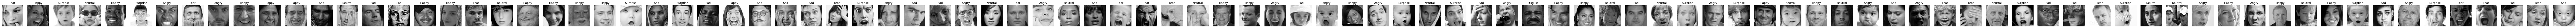



Predictions:



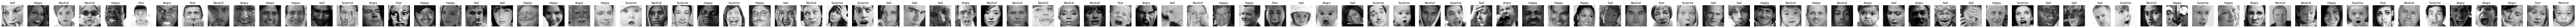

In [41]:
# Checking the output of the newly trained network on a random sample of n images from the test set
emotions = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]
images,indexes = random_images(X_test,n)
predictions = model.predict(images)

# Viewing the images in the batch with their correct labels
fig1 = plt.figure(figsize=(2*n, 2*n))
print("Groundtruth:\n")
j=1
for i in range(0,n):
  fig1.add_subplot(1,n,j)
  plt.axis("off")
  plt.imshow(images[i]/255,interpolation='nearest',cmap="gray")
  plt.title(emotions[y_test[indexes[i]].argmax()])
  j = j+1
plt.show(fig1)
print("\n")
# Viewing the images in the batch with their predicted labels
fig2 = plt.figure(figsize=(2*n, 2*n))
print("Predictions:\n")
j=1
for i in range(0,n):
  fig2.add_subplot(1,n,j)
  plt.axis("off")
  plt.imshow(images[i]/255,interpolation="nearest",cmap="gray")
  plt.title(emotions[predictions[i].argmax()])
  j = j+1
plt.show(fig2)



# Saving the model
After training and testing the model, it is saved for future loading.

In [ ]:
model.save(filepath="/content/drive/MyDrive/Facial-Expression-Recognition/ResNet152V2.h5")